# Match Class

In [ ]:
#| default_exp match_class
%load_ext autoreload
%autoreload 2

### Overview
The following module defines the **Match class**, that will be used by the Matcher module later. This class provides a subview to the graph which we attempt to transform, and is created based on some match from the LHS pattern to a subgraph of the input graph (Further explanations on the meaning of matches are included in the next module).

This subview is set such that read-write operations can be done on nodes and edges imperatively, based on their symbolic name (the node/edge they match in the pattern) rather than their actual name in the input graph. That is, we can access nodes and edges in the input graph which were matched to the pattern (and only them), by using their corresponding names in the pattern. 

For each match found, the user of the library will recieve its correpsonding Match object, which can be used for imperative side effects.

### Requirements

In [ ]:
#| export
import networkx as nx
from networkx import DiGraph
from typing import *
from graph_rewrite.core import _create_graph, _plot_graph, GraphRewriteException, NodeName, EdgeName

### Example
Assume that we have an input graph $G$:

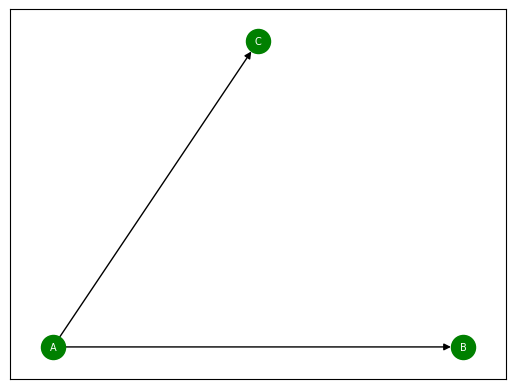

In [ ]:
_plot_graph(_create_graph(['A','B','C'], [('A','B'), ('A','C')]))

And a pattern which looks exactly the same, with different (symbolic) names:

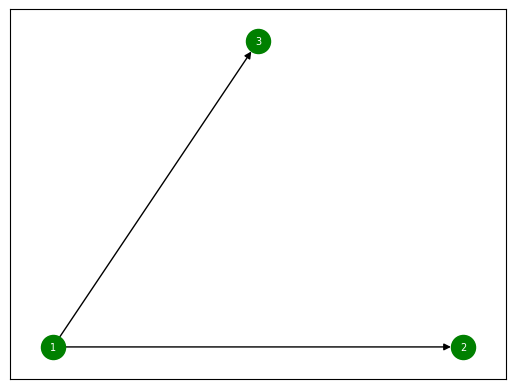

In [ ]:
_plot_graph(_create_graph(['1','2','3'], [('1','2'), ('1','3')]))

Intuitively, we can see that the pattern can be found in the input graph $G$, such that the pattern node $1$ corresponds to the graph node $A$, and the same goes for $2$ and $B$, $3$ and $C$. That mapping defines a match of the pattern in graph $G$ (We will dive into the definition of a match in the next module).

The corresponding Match object will allows us, for example, changing an attribute of node $A$ in the input graph, by accessing the symbolic name $1$ (which matches to $A$) and setting it to some dictionary of attributes. Note that the user will be able to access this class only after the transformation is done - therefore, if the transformation removed $A$ from the graph, the user won't be able to access the symbolic name $1$ anymore.

### Utils
Edge $(u,v)$ is represented in a Match with the name "u->v".

In [ ]:
#| export
def convert_to_edge_name(src: NodeName, dest: NodeName) -> str:
    """Given a pair of node names, source and destination, return the name of the edge
    connecting the two in the format {src}->{dest}, which is the same format the parser
    uses to create edges in the pattern graph.

    Args:
        src (NodeName): A node name
        dest (NodeName): A node name

    Returns:
        str: A representative name for the edge (src, dest).
    """
    return f"{src}->{dest}"

A node is **anonymous** if its name begins with '_'. This notion allows us to define patters with anonymous nodes, whose existence we want to enforce, but which we do not use in the RHS part of the pattern and thus, can ignore them by not assigning any symbolic name to them.

In [ ]:
#| export
def is_anonymous_node(node_name: NodeName) -> bool:
    """Given a name of a node in the pattern graph, return true if it begins with '$',
    which is the notion the parser uses to denote anonymous nodes.

    Args:
        node_name (NodeName): A node name in the pattern

    Returns:
        bool: Returns True if the node is anonymous, False otherwise.
    """
    return len(node_name) >= 1 and node_name[0] == '_'

### The Match Class

A **Match** is a subview of the original graph, limited to the nodes, edges and attributes specified in the pattern. It includes the original graph, dictionaries which map nodes/edges to their corresponding attributes in the pattern, and the mapping from pattern nodes to real ones.

In [ ]:
#| export
class Match:
    """Represents a single match of a pattern inside an input graph.
     Provides a subview to a graph, limited to the nodes, edges and attributes specified in the pattern.
    """
    def __init__(self, graph: DiGraph, nodes: List[NodeName], edges: List[EdgeName], mapping: Dict[NodeName, NodeName]):
        self.graph: DiGraph = graph
        self.__nodes: List[NodeName] = nodes
        self.__edges: List[EdgeName] = edges
        self.mapping: Dict[NodeName, NodeName] = mapping

    def __get_node(self, pattern_node):
        if pattern_node not in self.__nodes:
            raise GraphRewriteException(f"Node {pattern_node} does not exist in the pattern")
        return self.graph.nodes[self.mapping[pattern_node]]

    def __get_edge(self, pattern_src, pattern_dst):
        if (pattern_src, pattern_dst) not in self.__edges:
            raise GraphRewriteException(f"Edge {(pattern_src, pattern_dst)} does not exist in the pattern")
        return self.graph.edges[self.mapping[pattern_src], self.mapping[pattern_dst]]

    def nodes(self):
        return {pattern_node: self.__get_node(pattern_node) for pattern_node in self.__nodes}

    def edges(self):
        return {convert_to_edge_name(pattern_src, pattern_dest): self.__get_edge(pattern_src, pattern_dest) for (pattern_src, pattern_dest) in self.__edges}

    def __eq__(self, other):
        if type(other) is Match and len(other.mapping.items()) == len(self.mapping.items()):
            return all([other.mapping.get(k) == v for k,v in self.mapping.items()])
        return False

    def __getitem__(self, key: Union[NodeName, str]):
        """Returns the node / edge of the input graph, which was mapped by the key in the pattern during matching.

        Args:
            key (Union[NodeName, str]): A symbolic name used by the pattern (for a node / edge)

        Raises:
            GraphRewriteException: If the key doesn't exist in the pattern, or is mapped to a node / edge
            which does not exist anymore (due to removal by the transformation, for example).

        Returns:
            The corresponding node / edge of the input graph
        """
        try:
            if str(key).__contains__("->") and len(str(key).split("->")) == 2:
                end_nodes = str(key).split("->")
                return self.__get_edge(end_nodes[0], end_nodes[1])
            else:
                return self.__get_node(key)
        except:
            raise GraphRewriteException(f"The symbol {key} does not exist in the pattern, or it was removed from the graph")
        
    def __str__(self):
        return self.mapping.__str__()

### Create a Match
This function will be used in the Matcher module, in order to convert a mapping from the pattern graph to the input graph into a corresponding instance of the Match class.

In [ ]:
#| export
def mapping_to_match(input: DiGraph, pattern: DiGraph, mapping: Dict[NodeName, NodeName], filter: bool=True) -> Match:
    """Given a mapping, which denotes a match of the pattern in the input graph,
    create a corresponding instance of the Match class.

    Args:
        input (DiGraph): An input graph
        pattern (DiGraph): A pattern graph
        mapping (Dict[NodeName, NodeName]): A mapping from nodes in the pattern graph to nodes in the input graph, 
        that denotes a single match between the two.
        filter (bool, optional): If True, filter anonymous nodes and edges. Defaults to True.

    Returns:
        Match: A corresponding instance of the Match class
    """
    nodes_list, edges_list = [], []
    cleared_mapping = mapping.copy()

    for pattern_node in mapping.keys():
        if filter and is_anonymous_node(pattern_node):
            cleared_mapping.pop(pattern_node)
            continue # as we don't want to include this node in the Match
        nodes_list.append(pattern_node)

    for (n1, n2) in pattern.edges:
        if filter and (is_anonymous_node(n1) or is_anonymous_node(n2)):
            continue # as before
        edges_list.append((n1, n2))

    return Match(input, nodes_list, edges_list, cleared_mapping)

### Tests
We take the example graph and pattern described above, add a few attributes to the nodes and edges, and create a Match instance based on the single mapping:

In [ ]:
G = _create_graph(
    [('A', {'name': 'A'}),('B', {'name': 'B'}),('C', {'name': 'C'})],
    [('A','B', {'edge_attr': 10}), ('A','C')])
pattern = _create_graph(['1','2','3'], [('1','2'), ('1','3')])
# It has a single match, which is defined by the following mapping:
mapping = {'1': 'A', '2': 'B', '3': 'C'}
mapping_match = mapping_to_match(G, pattern, mapping)

In graph $G$, each node has a single attribute - "name" - whose value is the node's name. Therefore, node $A$ has the attribute "name" with the value "A". We can access its attributes using the Match, by accessing the name of the corresponding matched node $1$:

In [ ]:
assert mapping_match['1'] == {'name': 'A'}
assert mapping_match['1']['name'] == 'A'
mapping_match['1']

{'name': 'A'}

This indicates that as expected, pattern node $1$ is matched in this Match instance to the input graph node $A$, as that node is the only one in the graph whose "name" attribute is equal to "A".

We can access the edges similarly, by using the format {src}->{dst} for edge $(src, dst)$:

In [ ]:
assert mapping_match['1->2'] == {'edge_attr': 10}
mapping_match['1->2'] # accesses the attributes of the corresponding edge A->B in G

{'edge_attr': 10}

Say we want to add an attribute to $A$, we can change it in the same way using the Match:

In [ ]:
mapping_match['1']['attr'] = 5
assert mapping_match['1'] == {'name': 'A', 'attr': 5}
mapping_match['1']

{'name': 'A', 'attr': 5}

And then see that the attributes of $A$ in the original graph $G$ have changed, as the Match is a subview of that graph, and so changes in the subview are reflected in $G$:

In [ ]:
assert G.nodes(data=True)['A'] == {'name': 'A', 'attr': 5}
G.nodes(data=True)['A']

{'name': 'A', 'attr': 5}

We can also modify existing attributes in the same way using the Match, and see those changes reflected in $G$

In [ ]:
mapping_match['2']['name'] = 'B*'
assert mapping_match['2']['name'] == 'B*'
assert G.nodes(data=True)['B']['name'] == 'B*'
G.nodes(data=True)['B']

{'name': 'B*'}

This also works in the reverse direction: changes in $G$ are reflected in the subview. Say that we set an attribute for edge $(A,B)$ in $G$, then that change would be reflected by accessing the edge '1->2' in the Match object that refers graph $G$:

In [ ]:
G.edges()[('A','B')]['attr2'] = 20
assert mapping_match['1->2']['attr2'] == 20
mapping_match['1->2']

{'edge_attr': 10, 'attr2': 20}